In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

In [2]:
df = pd.read_csv("/content/spam.csv", encoding= 'latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)

In [4]:
df.rename(columns = {'v1' : 'label' , 'v2' : 'Text'}, inplace = True)
df.head()

,label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   Text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

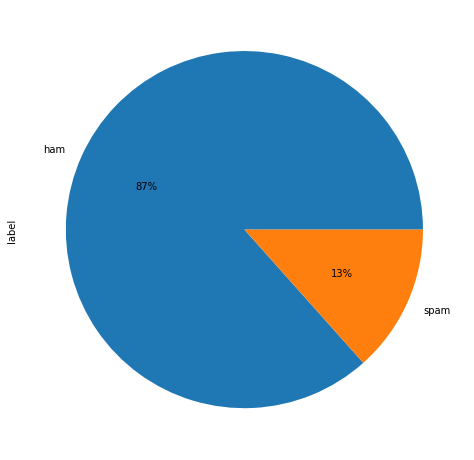

In [7]:
plt.rcParams["figure.figsize"] = [8,10] 
df["label"].value_counts().plot(kind='pie', autopct='%1.0f%%')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


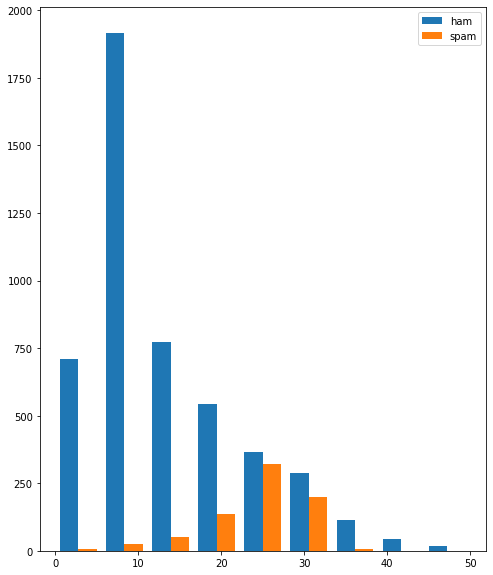

In [8]:
dataset_ham = df[df['label'] == "ham"]
dataset_ham_count = dataset_ham['Text'].str.split().str.len()
dataset_ham_count.index = dataset_ham_count.index.astype(str) + ' words:'
dataset_ham_count.sort_index(inplace=True)

dataset_spam = df[df['label'] == "spam"]
dataset_spam_count = dataset_spam['Text'].str.split().str.len()
dataset_spam_count.index = dataset_spam_count.index.astype(str) + ' words:'
dataset_spam_count.sort_index(inplace=True)

bins = np.linspace(0, 50, 10)

plt.hist([dataset_ham_count, dataset_spam_count], bins, label=['ham', 'spam'])
plt.legend(loc='upper right')
plt.show()

In [9]:
df["Text"][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [10]:
import re
# Defining a function to clean up the text
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowercase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

df["Text"] = df["Text"].apply(Clean)

df.head()

,label,Text
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in a wkly comp to win fa cup final ...
3,ham,u dun say so early hor u c already then say
4,ham,nah i don t think he goes to usf he lives arou...


In [11]:
import nltk
nltk.download('punkt')
df["Tokenize_Text"]=df.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1)

df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,label,Text,Tokenize_Text
0,ham,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ham,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,ham,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,..."


In [12]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
print(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'below', 'he', 'how', "shouldn't", 'on', 'ma', 'ain', 'they', 'themselves', 'yours', 'she', "aren't", 'has', 'aren', "mightn't", 'will', "isn't", 'under', 'shan', 'before', 'all', 'isn', "mustn't", 't', 'above', "doesn't", 'ours', 'haven', "didn't", "needn't", 'theirs', 'being', 'further', 'didn', 'after', 'an', 'my', 'wouldn', 'very', 'or', 'yourselves', "wouldn't", 'yourself', 'are', 'for', 'in', 'it', 'more', "hadn't", "wasn't", 'as', 'can', 'am', 'with', "shan't", 'her', 'down', 'where', 'each', 'did', 'had', 'during', 'is', 'don', 'too', 'weren', 'while', 's', "you'd", 'myself', 'which', 'a', 'nor', 'who', 'into', "it's", 'only', 'because', 'couldn', 'about', 've', 'him', 'both', 'herself', 'this', 'been', 'once', 'i', 'out', 'shouldn', 'but', 'does', 'doing', 'any', 'few', 'll', "you'll", 'through', 'y', 'than', 'such', 'what', "you've", 'himself', 'itself', 'there', 'h

In [13]:
# Removing the stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

df["Nostopword_Text"] = df["Tokenize_Text"].apply(remove_stopwords)

df.head()

,label,Text,Tokenize_Text,Nostopword_Text
0,ham,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,spam,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,ham,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]"


In [14]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

df["Lemmatized_Text"] = df["Nostopword_Text"].apply(lemmatize_word) 

df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,label,Text,Tokenize_Text,Nostopword_Text,Lemmatized_Text
0,ham,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,ham,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, live, around, though]"


TF-IDF in NLP stands for Term Frequency – Inverse document frequency. In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix. This is also known as word embedding or Word vectorization.

Term Frequency (TF) = (Frequency of a term in the document)/(Total number of terms in documents) Inverse Document Frequency(IDF) = log( (total number of documents)/(number of documents with term t)) I will be using TfidfVectorizer() to vectorize the preprocessed data.



In [15]:
corpus= []
for i in df["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]

['go jurong point crazy available bugis n great world la e buffet cine get amore wat',
 'ok lar joke wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think go usf live around though']

In [16]:
len(corpus)

5572

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Changing text data in to numbers. 
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature 
X.dtype

dtype('float64')

In [18]:
tfidf_tokens = tfidf.get_feature_names()
print(tfidf_tokens)

['aa', 'aah', 'aaniye', 'aaooooright', 'aathi', 'ab', 'abbey', 'abdomen', 'abeg', 'abel', 'aberdeen', 'abi', 'ability', 'abiola', 'abj', 'able', 'abnormally', 'aboutas', 'abroad', 'absence', 'absolutely', 'absolutly', 'abstract', 'abt', 'abta', 'aburo', 'abuse', 'abusers', 'ac', 'academic', 'acc', 'accent', 'accenture', 'accept', 'access', 'accessible', 'accidant', 'accident', 'accidentally', 'accommodation', 'accommodationvouchers', 'accomodate', 'accomodations', 'accordin', 'accordingly', 'account', 'accumulation', 'achan', 'ache', 'achieve', 'acid', 'acknowledgement', 'acl', 'acnt', 'aco', 'across', 'act', 'actin', 'action', 'activ', 'activate', 'active', 'activities', 'actor', 'actual', 'actually', 'ad', 'adam', 'add', 'addamsfa', 'addict', 'addie', 'address', 'adewale', 'adi', 'adjustable', 'admin', 'administrator', 'admirer', 'admission', 'admit', 'adore', 'adp', 'adress', 'adrian', 'ads', 'adsense', 'adult', 'adults', 'advance', 'adventure', 'advice', 'advise', 'advisors', 'ae',

In [19]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])

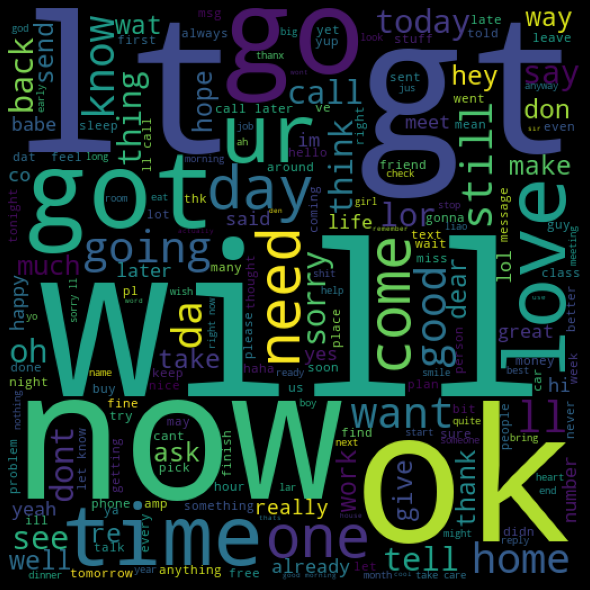

In [20]:
from wordcloud import WordCloud 
ham_words = ' '.join(list(df[df['label'] == 0]['Text']))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

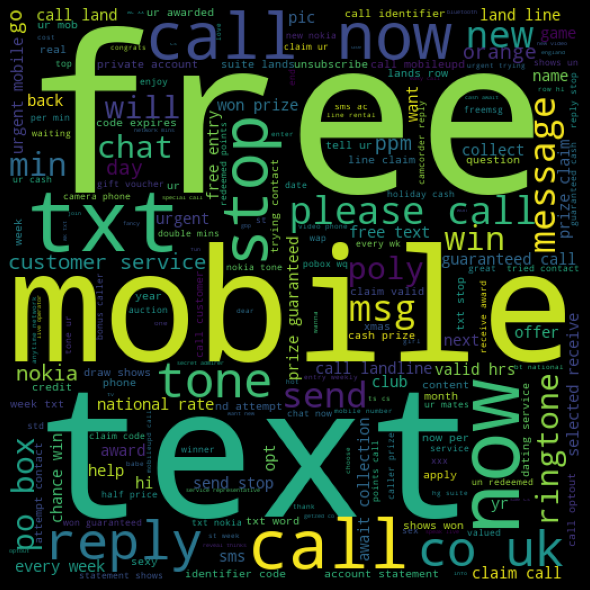

In [21]:
spam_words = ' '.join(list(df[df['label'] == 1]['Text']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [22]:
df.head()

,label,Text,Tokenize_Text,Nostopword_Text,Lemmatized_Text
0,0,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,0,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,1,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,0,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, live, around, though]"


In [23]:
from sklearn.model_selection import train_test_split
# Setting values for labels and feature as y and X(we already did X in vectorizing...)
y = df["label"] 
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
print(len(X_train))
print(len(X_test))

4457
1115


In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# Testing on the following classifiers

classifiers = [MultinomialNB(), 
               RandomForestClassifier(),
               KNeighborsClassifier(), 
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

In [26]:
# Cossvalidation 
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train, scoring= "accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.966568 
RandomForest: 0.978235 
KNeighbours: 0.914740 
SVC: 0.976217 


In [27]:
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics
# Model Evaluation
# creating lists of various scores
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = i.score(X_train,y_train)
    test_accuracy = i.score(X_test,y_test)
  
    # Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [28]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])
Results

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,0.990991,0.733333,0.842912,0.963229,0.975768
RandomForest,1.000000,0.826667,0.905109,0.976682,1.000000
KNeighbours,1.000000,0.400000,0.571429,0.919283,0.927081
SVC,0.992063,0.833333,0.905797,0.976682,0.997981


In [29]:
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,0.990991,0.733333,0.842912,0.963229,0.975768
RandomForest,1.000000,0.826667,0.905109,0.976682,1.000000
KNeighbours,1.000000,0.400000,0.571429,0.919283,0.927081
SVC,0.992063,0.833333,0.905797,0.976682,0.997981


In [32]:
clf = RandomForestClassifier()

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [33]:
cross_val_score(clf, X_train,y_train, scoring= "accuracy", cv=10)

array([0.97533632, 0.98430493, 0.98878924, 0.97085202, 0.97982063,
       0.97085202, 0.98206278, 0.9752809 , 0.98426966, 0.96629213])

In [34]:
import pickle 
save_documents = open("model.pickle","wb")
pickle.dump(clf, save_documents)
save_documents.close()